<a href="https://colab.research.google.com/github/tnfru/colab_research/blob/master/ARC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
import json
from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np

if 'google.colab' in sys.modules:
  %tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras import Sequential

TensorFlow 2.x selected.


## Set up hardware

In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus)
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Running on  1  GPU(s) 


# Read Data

In [0]:
gdd.download_file_from_google_drive(file_id='1FUk30rXuym1RygfaDq4g-Uj-CkkG63IE',
                                    dest_path='./data/arc.zip',
                                    unzip=True)

In [0]:
PATH = Path('./data/')
TRAIN_PATH = PATH / 'training'
VAL_PATH = PATH / 'evaluation'
TEST_PATH = PATH / 'test'

In [0]:
def read_tasks(path):
  files = sorted(os.listdir(path))
  tasks = []

  for file in files:
    task_file = str(path / file)

    with open(task_file, 'r') as f:
      task = json.load(f)

    tasks.append(task)
  
  return tasks

In [6]:
train_tasks = read_tasks(TRAIN_PATH)
val_tasks = read_tasks(VAL_PATH)
test_tasks = read_tasks(TEST_PATH)

len(train_tasks), len(val_tasks), len(test_tasks)

(400, 400, 100)

# Data Vizualization

#### Plot function

In [0]:
def plot_example(ax, task, i, isType):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)

    ax[0].imshow(task[isType][i]['input'], cmap=cmap, norm=norm)
    ax[0].axis('off')
    ax[0].set_title(isType + ' Input')
    ax[0].grid(True,which='both',color='lightgrey', linewidth=0.5)
    ax[1].imshow(task[isType][i]['output'], cmap=cmap, norm=norm)
    ax[1].axis('off')
    ax[1].set_title(isType + ' Output')
    ax[1].grid(True,which='both',color='lightgrey', linewidth=0.5)

def plot_task(task):
    """
    credits: 
    kaggle.com/inversion/abstraction-and-reasoning-starter-notebook
    kaggle.com/boliu0/visualizing-all-task-pairs-with-gridlines/notebook
    """
    task_count = len(task['train'])
    test_count = len(task['test'])

    fig, ax = plt.subplots(2, task_count , figsize=(10,6))

    for i in range(task_count):
      plot_example(ax[:,i], task, i, 'train')

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(2, test_count , figsize=(6,6))
    
    if test_count == 1:
      plot_example(ax, task, 0, 'test')
    else:
      for i in range(test_count):
        plot_example(ax[:,i], task, i, 'test')

    plt.tight_layout()
    plt.show()

## Visualize some tasks

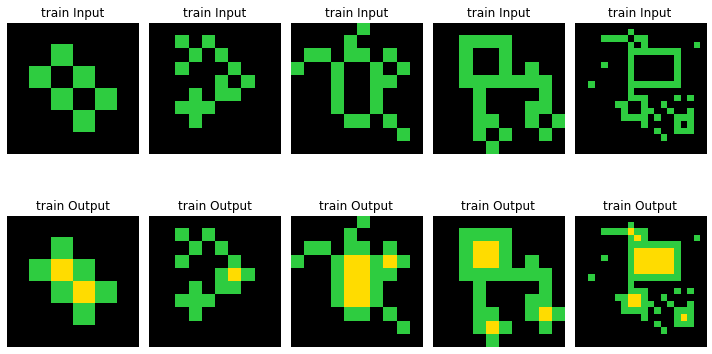

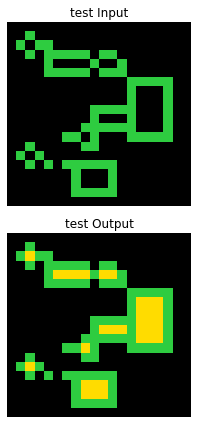

In [8]:
plot_task(train_tasks[1])

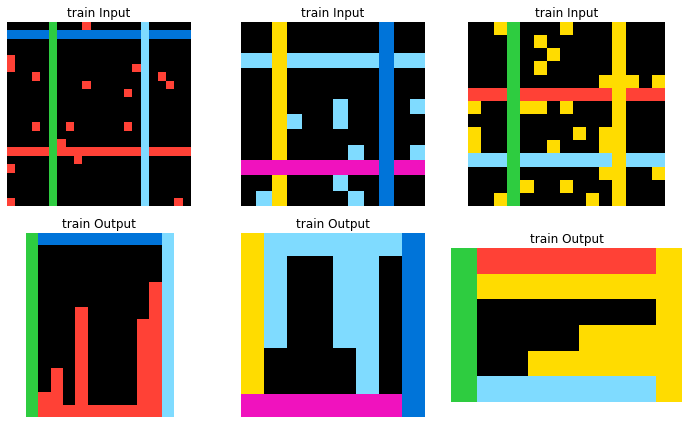

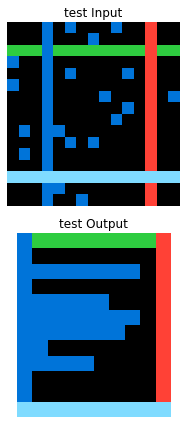

In [9]:
plot_task(train_tasks[137])

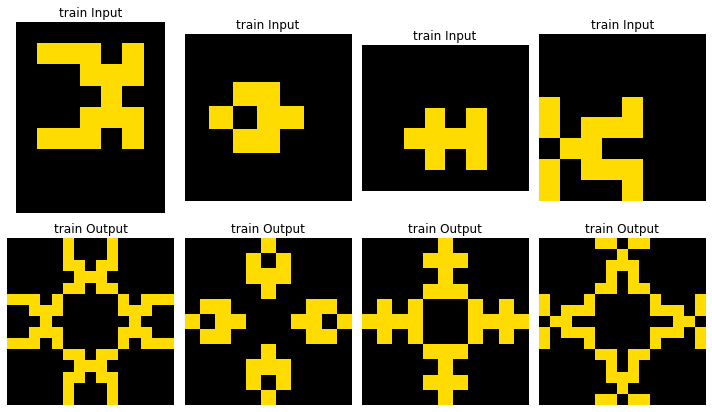

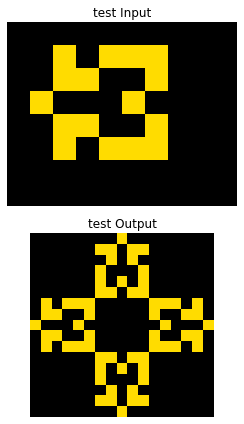

In [10]:
plot_task(val_tasks[64])

# Transform data

In [19]:
train_tasks[1]['train'][0]['input']

[[0, 0, 0, 0, 0, 0],
 [0, 0, 3, 0, 0, 0],
 [0, 3, 0, 3, 0, 0],
 [0, 0, 3, 0, 3, 0],
 [0, 0, 0, 3, 0, 0],
 [0, 0, 0, 0, 0, 0]]

In [20]:
train_tasks[1]['train'][0]['output']

[[0, 0, 0, 0, 0, 0],
 [0, 0, 3, 0, 0, 0],
 [0, 3, 4, 3, 0, 0],
 [0, 0, 3, 4, 3, 0],
 [0, 0, 0, 3, 0, 0],
 [0, 0, 0, 0, 0, 0]]

In [23]:
train_tasks[1]['test'][0]

{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 3, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 0, 0],
  [0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0],
  [0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 3, 0, 3, 0, 3, 3, 3, 3